In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import squidpy as sq
import anndata as ad
import seaborn as sns
import simstpy as sim

In [2]:
df_spatial = pd.read_csv("./human_brain_10x.csv", index_col=0)
library_ids = list(df_spatial['sample_id'].unique())

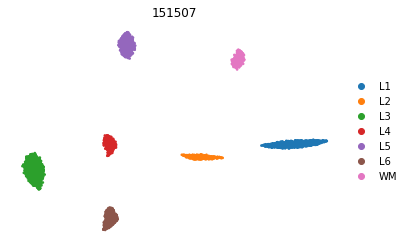

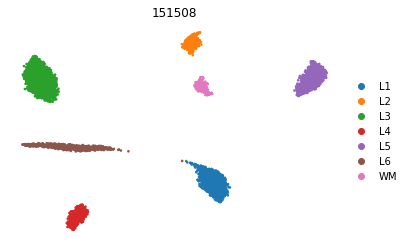

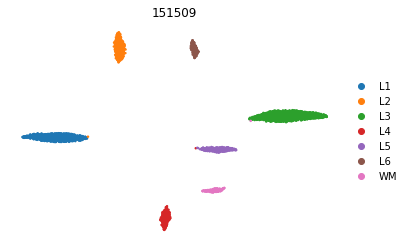

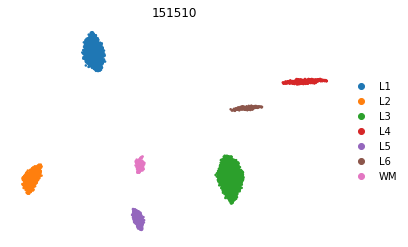

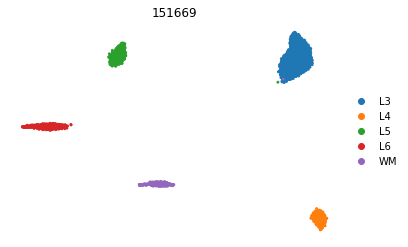

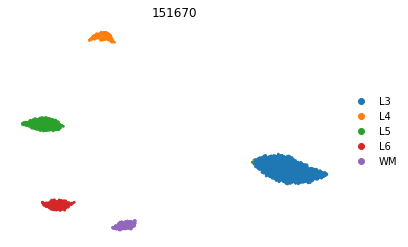

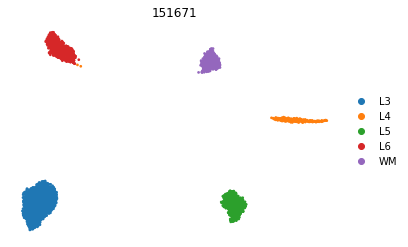

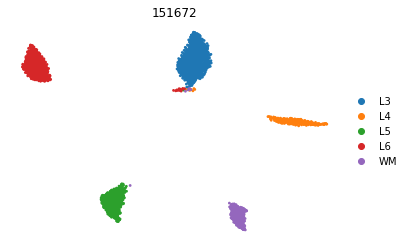

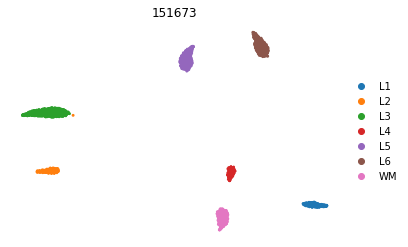

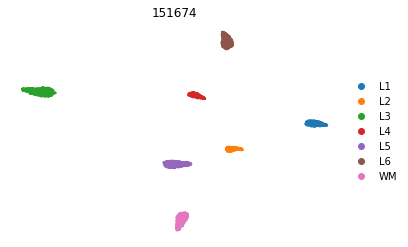

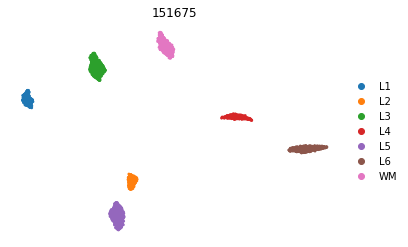

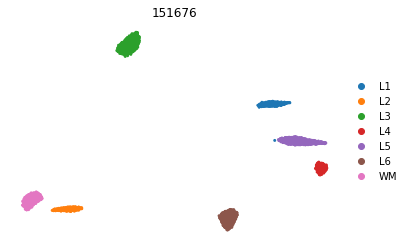

In [3]:
for library_id in library_ids:
    adata = sc.read_h5ad(f"./reference/{library_id}.h5ad")
    
    library_size_params = sim.rna.fit_library_size(adata.layers['counts'])
    gene_mean_params = sim.rna.fit_mean_expression_gamma(adata.X, q=0.99)
    
    sim_adata = sim.rna.simulate_multi_group(library_size_params,
                                    gene_mean_params, n_cells=adata.n_obs, n_genes=adata.n_vars,
                                    obs=adata.obs, group_name="spatialLIBD", n_marker_genes=100)
    
    sim_adata = sim.rna.add_spatial_assay_10x(sim_adata, str(library_id), f'./reference/{library_id}')
    
    sim_adata.layers['counts'] = sim_adata.X.copy()
    sc.pp.normalize_total(sim_adata, target_sum=1e4)
    sc.pp.log1p(sim_adata)
    sc.pp.pca(sim_adata)
    sc.pp.neighbors(sim_adata)
    sc.tl.umap(sim_adata)
    sc.pl.umap(sim_adata, color=["spatialLIBD"], frameon=False, title=f'{library_id}')
    
    sim_adata.write_h5ad(f"./simulated/{library_id}.h5ad")